C:\Users\hp\AppData\Local\Temp\ipykernel_42368\914111692.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_for_viz.rename(columns={


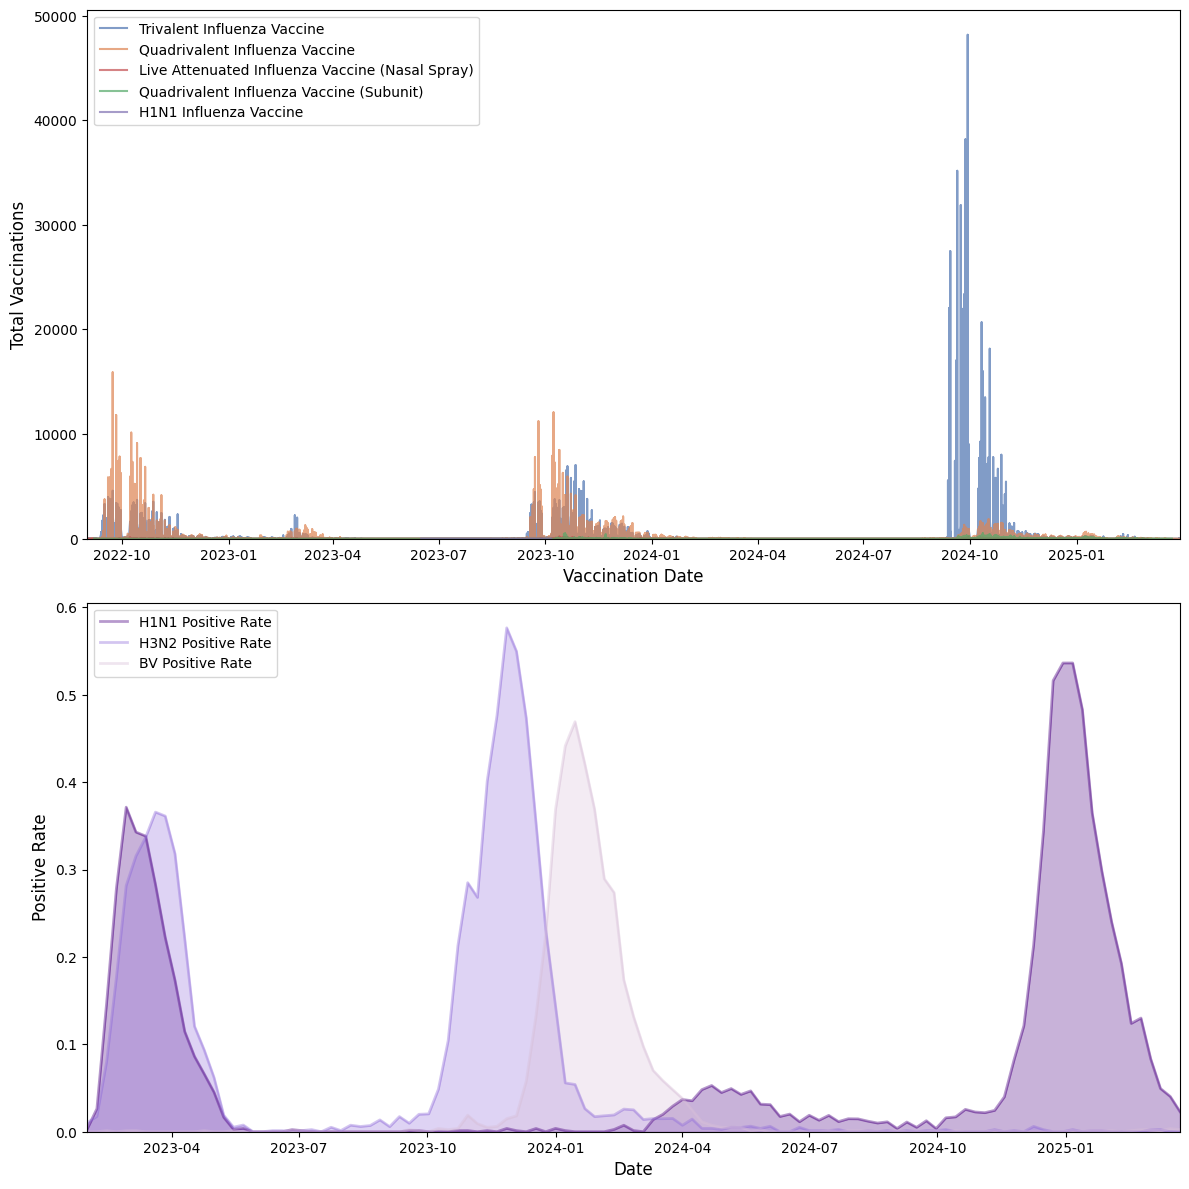

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 加载疫苗接种数据
file_path_vaccine = './data/newdata/疫苗接种数据_疫苗2.xlsx'

# 读取Excel文件
data_vaccine = pd.read_excel(file_path_vaccine)

# 筛选 'virus' 列中值为 'flu' 的数据，并去除 NA 的 age_group
flu_data = data_vaccine[data_vaccine['virus'] == 'flu']
flu_data = flu_data[flu_data['age_group'].notna()]  # 确保去掉 NA 的值

# 确保 'VACCINATION_DATE' 是日期格式
flu_data['VACCINATION_DATE'] = pd.to_datetime(flu_data['VACCINATION_DATE'])

# 筛选 2022 年 9 月 1 日及之后的数据
flu_data = flu_data[flu_data['VACCINATION_DATE'] >= '2022-09-01']

# 合并年龄组：将 '59-79' 和 '79以上' 合并为 '59+'
flu_data['age_group'] = flu_data['age_group'].replace({'(59,79]': '[60,inf]', '(79, Inf]': '[60,inf]'})

# 添加“全人群”组别
all_population = flu_data.copy()
all_population['age_group'] = 'All Population'
flu_data = pd.concat([flu_data, all_population])

# 替换 group 的名称为英文
group_name_mapping = {
    1: 'Trivalent Influenza Vaccine',
    2: 'Quadrivalent Influenza Vaccine',
    3: 'Quadrivalent Influenza Vaccine (Subunit)',
    4: 'Live Attenuated Influenza Vaccine (Nasal Spray)',
    5: 'H1N1 Influenza Vaccine'
}
flu_data['group'] = flu_data['group'].replace(group_name_mapping)

# 新配色方案
color_mapping = {
    'Trivalent Influenza Vaccine': '#4c72b0',  # 深蓝
    'Quadrivalent Influenza Vaccine': '#dd8452',  # 橙色
    'Quadrivalent Influenza Vaccine (Subunit)': '#55a868',  # 绿色
    'Live Attenuated Influenza Vaccine (Nasal Spray)': '#c44e52',  # 红色
    'H1N1 Influenza Vaccine': '#8172b2'  # 紫色
}

# 只选择全人群的数据
flu_data_all_population = flu_data[flu_data['age_group'] == 'All Population']

# 加载流感亚型阳性率数据
file_path_influenza = './data/newdata/variant.xlsx'  # 数据文件路径
data_influenza = pd.ExcelFile(file_path_influenza)

# 读取第二张表格并处理
sheet2_data = data_influenza.parse('Sheet1')
sheet2_data['起始日期'] = pd.to_datetime(sheet2_data['起始日期'])  # 转换日期格式

# 提取相关列（已经是阳性率）
data_for_viz = sheet2_data[['起始日期', '甲型H1N1阳性率', '甲型 H3N2阳性率', '乙型BV阳性率']]
data_for_viz.rename(columns={
    '甲型H1N1阳性率': 'H1N1 Positive Rate',
    '甲型 H3N2阳性率': 'H3N2 Positive Rate',
    '乙型BV阳性率': 'BV Positive Rate'
}, inplace=True)

# 设置日期为索引
data_for_viz.set_index('起始日期', inplace=True)

# 设置颜色和透明度（深紫、中紫、浅紫）
colors = ['#4B0082', '#9370DB', '#D8BFD8']  # 深紫色、紫罗兰、中紫色
alpha = 0.3  # 填充色透明度

# 创建 2 个子图：一个在上面，一个在下面
fig, axs = plt.subplots(2, 1, figsize=(12, 12))  # 2 行 1 列的布局

# 绘制疫苗接种数据趋势图（上图）
for group in flu_data_all_population['group'].unique():
    group_subset = flu_data_all_population[flu_data_all_population['group'] == group]
    group_subset = group_subset.sort_values('VACCINATION_DATE')  # 按日期排序
    axs[0].plot(group_subset['VACCINATION_DATE'], group_subset['total'], 
                label=f'{group}', color=color_mapping[group], alpha=0.7)  # 设置透明度alpha=0.7

axs[0].set_xlabel('Vaccination Date', fontsize=12)
axs[0].set_ylabel('Total Vaccinations', fontsize=12)
axs[0].legend(loc='upper left', fontsize=10, ncol=1)
axs[0].set_ylim(bottom=0)  # 确保y轴从0开始
axs[0].margins(x=0, y=0)  # 去除额外的间隙

# 绘制流感亚型阳性率趋势图（下图）
for idx, column in enumerate(data_for_viz.columns):
    axs[1].plot(data_for_viz.index, data_for_viz[column], label=column, color=colors[idx], linewidth=2 ,alpha=0.4)
    axs[1].fill_between(data_for_viz.index, 0, data_for_viz[column], color=colors[idx], alpha=alpha)

axs[1].set_xlabel('Date', fontsize=12)
axs[1].set_ylabel('Positive Rate', fontsize=12)
axs[1].legend(loc='upper left', fontsize=10, ncol=1)
axs[1].set_ylim(bottom=0)  # 确保y轴从0开始
axs[1].margins(x=0, y=0)  # 去除额外的间隙

# 调整布局
plt.tight_layout()
# 保存图表为PDF，dpi=450
plt.savefig('vaccination_and_influenza_trends.pdf', dpi=450, format='pdf')
# 显示图表
plt.show()
